In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [3]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [41]:
a1 = 40
a2 = 45
eps_back = 1.473**2

# del_d = 4*a1

d = 2.5*a1
d_col_nm = np.array([[d, 0, 0]])*1e-7

# hw = 2.2
sensorsize_nm = 1000

plot_hws = np.linspace(2.2, 2.7, 300)

In [42]:
## Assign materialk porperties
au_eps_inf=9.82335326  # eps_inf
au_w_p=9.06705560/hbar  # w_p
au_gamma=0.0334860149/hbar  # gamma

In [43]:
def alpha_1_of_hw(hw):
    return cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
#         eps_inf=14.2, 
#         w_p=10.0/hbar, 
#         gamma=0.20/hbar,
#         eps_b=1.33**2., 
        a=a1*1e-7, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )

def alpha_2_of_hw(hw):
    return cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
        a=a2*1e-7, 
        )

Text(0.5, 1.0, 'Heterodimer Scattering')

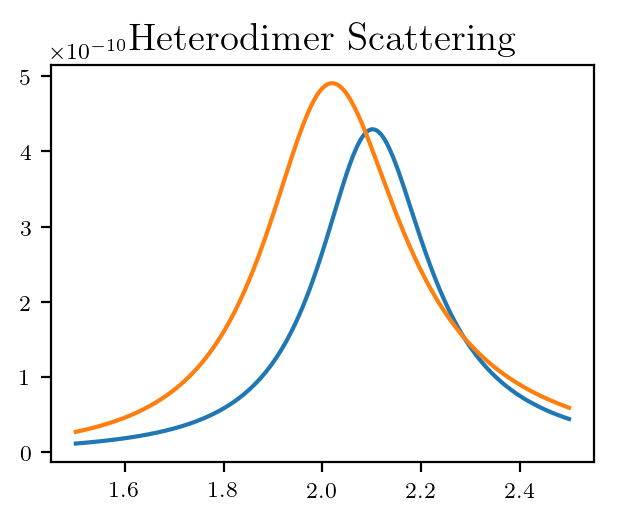

In [44]:
plot_hws = np.linspace(1.5, 2.5, 300)

sphere_1_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_1_of_hw(plot_hws)[:, 0, 0])**2.
    )
sphere_2_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_2_of_hw(plot_hws)[:, 0, 0])**2.
    )

plt.plot(plot_hws, sphere_1_scattering)
plt.plot(plot_hws, sphere_2_scattering)
plt.title("Heterodimer Scattering")

In [45]:
def coupled_dips_of_w(w):
    return  cp.coupled_dip_mags_both_driven(
        mol_angle=0,
        plas_angle=0,
        d_col = d_col_nm,
        E_d_angle=None,
        drive_hbar_w=w*hbar,
        alpha0_diag=alpha_1_of_hw(w*hbar),
        alpha1_diag=alpha_2_of_hw(w*hbar),
        n_b=eps_back**0.5,
        drive_amp=1,)

coupled_scattering = cp.sigma_scat_coupled(
    dipoles_moments_per_omega=coupled_dips_of_w,
    d_col=d_col_nm,
    drive_hbar_w=plot_hws,
    n_b=eps_back**0.5,
    E_0=1,)

In [46]:
coupled_scattering[0].shape

(300,)

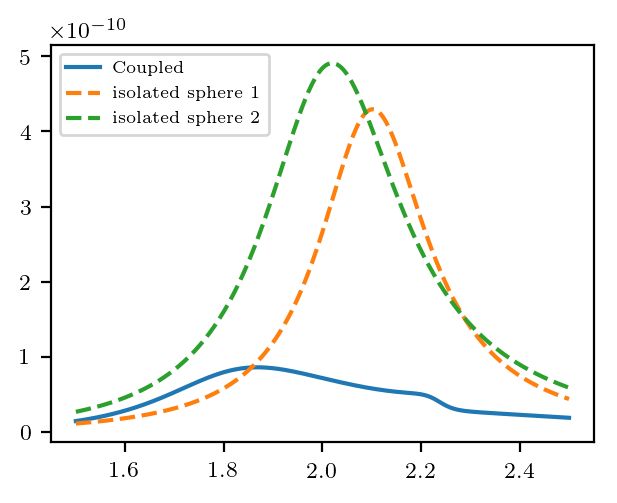

In [49]:
plt.plot(plot_hws, coupled_scattering[0], label='Coupled')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

plt.plot(plot_hws, sphere_1_scattering, ls='--', label='isolated sphere 1')
plt.plot(plot_hws, sphere_2_scattering, ls='--', label='isolated sphere 2')
plt.legend(fontsize=6)

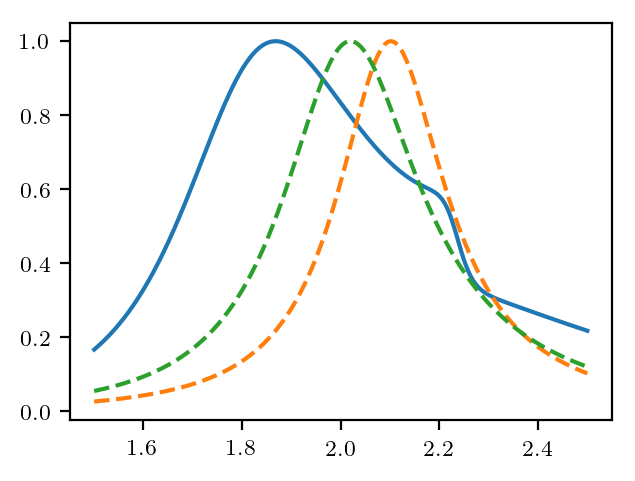

In [50]:
plt.plot(plot_hws, coupled_scattering[0]/coupled_scattering[0].max(), label='Coupled')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

plt.plot(plot_hws, sphere_1_scattering/sphere_1_scattering.max(), ls='--', label='isolated sphere 1')
plt.plot(plot_hws, sphere_2_scattering/sphere_2_scattering.max(), ls='--', label='isolated sphere 2')

Find peak energies

In [51]:
bond_enei = plot_hws[np.argmax(coupled_scattering[0])]
anti_enei = plot_hws[round(len(plot_hws)/2)+
    np.argmax(coupled_scattering[0][round(len(plot_hws)/2):])]

In [52]:
bond_enei

1.8678929765886287

In [53]:
anti_enei

2.0016722408026757

# CAlculate coupled abs for pump excitation

In [54]:
eps_at_bond = cp.drude_model(
    w=bond_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)
eps_at_anti = cp.drude_model(
    w=anti_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)

In [55]:
# eps1 = -2.5676 + 1j*3.6391
n0 = eps_back
eps0 = n0**2

Eplane = (1.4444)**0.5 * 10**18 * 10**(-1)

def elec(dip_angle, x, y, k):
    """ Dipole field of an x oriented dipole"""
    
    E = aff.E_field(
        dipole_orientation_angle=dip_angle, 
        xi=x, 
        y=y, 
        k=k
        )
    
    return E/k**3


def g(
    d_angle,
    d, w, 
    scale=1, 
    n_b=n0,
    p1_angle=0, p2_angle=0,):
    
    ## rotate d vector
    R = cp.rotation_by(d_angle)
    d_col = (R @ np.array([[d, 0, 0]]).T).T
    
    ## Get coupling strength from misloc package
    G = cp.G(
        drive_hbar_w=hbar*w, 
        d_col=d_col, 
        n_b=n_b)
    ## but this was implemented to process multiple seperations d or 
    ## frequencies w, so returns shape (1, 3, 3)
    if G.shape[0] is 1:
        G = G[0]
    
    def p_hat(angle):
        return cp.rotation_by(angle) @ np.array([1,0,0])[:,None]
    
    g = p_hat(p1_angle).T @ G @ p_hat(p2_angle)
    
    return g[...,0,:]


def p_coupled(
    w, d,
    alpha, other_alpha,
    probe_E=Eplane):

    p = (
        (alpha*(1 + g(0, d, w,)*other_alpha)*probe_E)
        /
        (1 - alpha*other_alpha*g(0, d, w,)**2)
        ) 
    
    if len(p.ravel()) is 1:
        p = p.ravel()
    
    return p

def pow_abs_coupled(
    w, d,
    alpha, that_alpha,
    x_dip=None,
    x_that_dip=None,
    x_obs=None,    
    probe_E=Eplane,
    n_b=n0,
    imaging_mode=None
    ): 
    """ Defines the power absorbed by one of two coupled dipoles.
    
        Assumes scalar polarizabilities
        """
    x_obs = np.asarray(x_obs)
    
    if x_dip is None and x_that_dip is None:
        x_dip = -d/2
        x_that_dip = d/2
    
    if imaging_mode is None:
        raise ValueError("'imaging_mode' must be 'wf' or 'cf'")
        
    k = w*n_b/c    
    _g = g(0, d, w,)
    
    ## Set up incident field depensing on imaging modality
    if imaging_mode is 'cf':
        if x_obs is None:
            raise ValueError("Need 'x_obs' if 'imaging_mode'='cf'")
        ## Define spactially dependent driving field
        this_probe_E = elec(
            0, 
            x=x_dip-x_obs,
            y=0, 
            k=k
            )[0] * probe_E
        that_probe_E = elec(
            0, 
            x=x_that_dip-x_obs,
            y=0, 
            k=k
            )[0] * probe_E
    elif imaging_mode is 'wf':
        this_probe_E = probe_E
        that_probe_E = probe_E
        
    ## Work done on dipole by incident field and coupling
    E_tot_time_geom_coupling = (
        (this_probe_E + _g*that_alpha*that_probe_E)
        /
        (1 - alpha*that_alpha*_g**2)
        )
    
    p = alpha*E_tot_time_geom_coupling 
    
    alpha_inv_star_dot_p_star = np.conj(E_tot_time_geom_coupling) 
    
    term_1 = np.imag(p * alpha_inv_star_dot_p_star)
    
    ## Define work done on dipole by its own field (Larmore power)
    term_2 = (2/3) * k**3. * np.abs(p)**2. 
    
    _pow_abs = w/2 * (term_1 - term_2)
    
    return _pow_abs

In [56]:
bond_alpha_1 = alpha_1_of_hw(bond_enei)
bond_alpha_2 = alpha_2_of_hw(bond_enei)

Text(0.5, 1.0, 'Power abs. by 40 nm and 45 nm spheres')

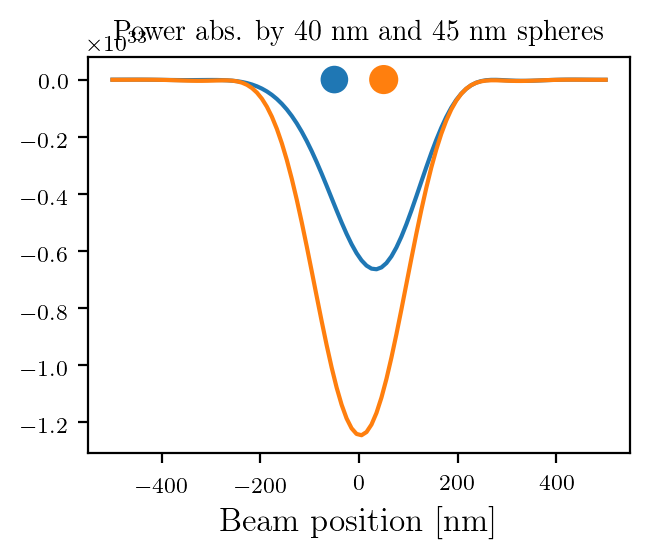

In [58]:
obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

bond_pow_test_1 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=bond_enei/hbar, 
    d=d*1e-7,
    alpha=bond_alpha_1[0,0], 
    that_alpha=bond_alpha_2[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

bond_pow_test_2 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=+d*1e-7/2,
    x_that_dip=-d*1e-7/2,
    w=bond_enei/hbar, 
    d=d*1e-7,
    alpha=bond_alpha_2[0,0], 
    that_alpha=bond_alpha_1[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

plt.plot(obs_points*1e7, bond_pow_test_1)
plt.plot(obs_points*1e7, bond_pow_test_2)
plt.xlabel('Beam position [nm]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.title('Power abs. by 40 nm and 45 nm spheres', fontsize=10)



Woh. Could this be correct? Is the total absorption negative?

In [18]:
np.any((bond_pow_test_1 + bond_pow_test_2)<0)

True

In [19]:
anti_alpha_1 = alpha_1_of_hw(anti_enei)
anti_alpha_2 = alpha_2_of_hw(anti_enei)

Text(0.5, 1.0, 'Power abs. by 10 nm and 15 nm spheres')

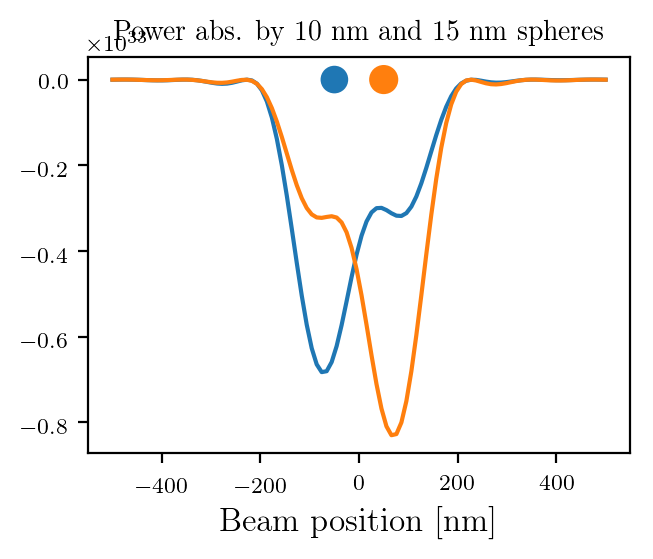

In [20]:
obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

anti_pow_test_1 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=anti_enei/hbar, 
    d=d*1e-7,
    alpha=anti_alpha_1[0,0], 
    that_alpha=anti_alpha_2[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

anti_pow_test_2 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=+d*1e-7/2,
    x_that_dip=-d*1e-7/2,
    w=anti_enei/hbar, 
    d=d*1e-7,
    alpha=anti_alpha_2[0,0], 
    that_alpha=anti_alpha_1[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

plt.plot(obs_points*1e7, anti_pow_test_1)
plt.plot(obs_points*1e7, anti_pow_test_2)
plt.xlabel('Beam position [nm]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.title('Power abs. by 10 nm and 15 nm spheres', fontsize=10)

